In [1]:
import time
import re
import pylab as pl
import numpy as np
import pylab as pl

from datetime import datetime, timedelta

import subprocess

import os
import pandas as pd



from joblib import Parallel, delayed
import shutil


from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

In [2]:
# time.sleep(120)

In [3]:
def str2datetime(s):
    parts = s.split('.')
    dt = datetime.strptime(parts[0], "%Y-%m-%d %H:%M:%S")
    return dt.replace(microsecond=int(parts[1]))


def remove_outliers(x, outlierConstant = 1.5):
    a = np.array(x)
    upper_quartile = np.percentile(a, 75)
    lower_quartile = np.percentile(a, 25)
    IQR = (upper_quartile - lower_quartile) * outlierConstant
    quartileSet = (lower_quartile - IQR, upper_quartile + IQR)
    resultList = []
    removedList = []
    for y in a.tolist():
        if y >= quartileSet[0] and y <= quartileSet[1]:
            resultList.append(y)
        else:
            removedList.append(y)
    return (resultList, removedList)
def getThroughput(experiment):

    result = subprocess.check_output('cat ../'+experiment+'/nohup_client_*', shell=True)


    result = result.decode("utf-8") 

    lines = result.split('\n')

#     commit_pat = re.compile('([^[].*) \[hotstuff info\] ([0-9.]*)$')
    commit_pat = re.compile('([^[].*) \[hotstuff info\] got*')

    Times = []
    lats = []

    for line in lines:
        m = commit_pat.match(line)
        if m:
            try:

                time_item = float((line.split(' ')[1]).split(':')[0])*3600 + float((line.split(' ')[1]).split(':')[1])*60 + \
                float((line.split(' ')[1]).split(':')[2])
                Times.append(time_item)        

                lats.append(float(m.group(2)))
            except:
                continue


    begin_time = None
    values = []
    interval = 1
    cnt = 0
    Times.sort()
    for timestamp in Times:
        if begin_time is None:
            begin_time = timestamp
            next_begin_time = timestamp +interval

        while timestamp >= next_begin_time:
            begin_time = next_begin_time
            next_begin_time += interval
            values.append(cnt)
            cnt = 0
        cnt += 1
    values.append(cnt)
    
#     lats, _ = remove_outliers(lats)
#     print(len(values))


    return np.arange(len(values))*interval,np.array(values)/interval, lats

In [4]:
# p = subprocess.Popen(['../../hotstuff-keygen', ' --num', '--n', str(4)],
#                      stdout=subprocess.PIPE, stderr=open(os.devnull, 'w'))

In [5]:
# print([[t[4:] for t in l.decode('ascii').split()] for l in p.stdout])
# # [[t for t in l.decode('ascii').split()] for l in p.stdout.read()]

In [6]:
# os.system('echo 3108 | sudo -S sh job_mini.sh '+ 'test')


In [7]:
# regions= ['us-west-1', 'ap-south-1']
# regions= ['ap-south-1', 'eu-central-1', 'us-west-2']
# regions= ['ap-south-1', 'eu-central-1']
regions= ['ap-south-1']


instance_type = 't2.small'

In [8]:
# df

In [9]:

# # Node config for remote view change and leader/non leader failures

# %%file node_info.csv
# node_id,region,ServerOrClientregion,cluster_id,key_file,clientID,ServerID, PublicIp
# 0, 'ap-south-1', 0, 0, 'FKA.pem', -1, 0,
# 1, 'ap-south-1', 0, 0, 'FKA.pem', -1, 1,
# 2, 'ap-south-1', 0, 0, 'FKA.pem', -1, 2,
# 3, 'ap-south-1', 0, 0, 'FKA.pem', -1, 3,
# 4, 'ap-south-1', 0, 0, 'FKA.pem', -1, 4,
# 5, 'ap-south-1', 0, 0, 'FKA.pem', -1, 5,
# 6, 'ap-south-1', 0, 0, 'FKA.pem', -1, 6,
# 7, 'ap-south-1', 0, 0, 'FKA.pem', -1, 7,
# 8, 'ap-south-1', 0, 0, 'FKA.pem', -1, 8,
# 9, 'ap-south-1', 0, 0, 'FKA.pem', -1, 9,
# 10, 'ap-south-1', 0, 0, 'FKA.pem', -1, 10,
# 11, 'ap-south-1', 0, 0, 'FKA.pem', -1, 11,
# 12, 'ap-south-1', 0, 0, 'FKA.pem', -1, 12,
# 13, 'ap-south-1', 0, 0, 'FKA.pem', -1, 13,
# 14, 'ap-south-1', 0, 0, 'FKA.pem', -1, 14,
# 15, 'ap-south-1', 0, 0, 'FKA.pem', -1, 15,
# 16, 'ap-south-1', 0, 0, 'FKA.pem', -1, 16,
# 17, 'ap-south-1', 0, 0, 'FKA.pem', -1, 17,
# 18, 'ap-south-1', 0, 0, 'FKA.pem', -1, 18,
# 19, 'ap-south-1', 0, 0, 'FKA.pem', -1, 19,
# 20, 'ap-south-1', 1, -1, 'FKA.pem', 0, -1,
# 21, 'ap-south-1', 1, -1, 'FKA.pem', 1, -1,



In [10]:
# %%file node_info.csv
# node_id,region,ServerOrClientregion,cluster_id,key_file,clientID,ServerID, PublicIp
# 0, 'ap-south-1', 0, 0, 'FKA.pem', -1, 0,
# 1, 'ap-south-1', 0, 0, 'FKA.pem', -1, 1,
# 2, 'ap-south-1', 0, 0, 'FKA.pem', -1, 2,
# 3, 'ap-south-1', 0, 0, 'FKA.pem', -1, 3,
# 4, 'ap-south-1', 0, 0, 'FKA.pem', -1, 4,
# 5, 'ap-south-1', 0, 0, 'FKA.pem', -1, 5,
# 6, 'ap-south-1', 0, 0, 'FKA.pem', -1, 6,
# 7, 'ap-south-1', 0, 0, 'FKA.pem', -1, 7,
# 8, 'ap-south-1', 0, 1, 'FKA.pem', -1, 8,
# 9, 'ap-south-1', 0, 1, 'FKA.pem', -1, 9,
# 10, 'ap-south-1', 0, 1, 'FKA.pem', -1, 10,
# 11, 'ap-south-1', 0, 1, 'FKA.pem', -1, 11,
# 12, 'ap-south-1', 0, 1, 'FKA.pem', -1, 12,
# 13, 'ap-south-1', 0, 1, 'FKA.pem', -1, 13,
# 14, 'ap-south-1', 0, 1, 'FKA.pem', -1, 14,
# 15, 'ap-south-1', 0, 1, 'FKA.pem', -1, 15,
# 16, 'ap-south-1', 1, -1, 'FKA.pem', 0, -1,
# 17, 'ap-south-1', 1, -1, 'FKA.pem', 1, -1,
# 18, 'ap-south-1', 1, -1, 'FKA.pem', 2, -1,
# 19, 'ap-south-1', 1, -1, 'FKA.pem', 3, -1,
# 20, 'eu-central-1', 0, 2, 'FKE.pem', -1, 16,
# 21, 'eu-central-1', 0, 2, 'FKE.pem', -1, 17,
# 22, 'eu-central-1', 0, 2, 'FKE.pem', -1, 18,
# 23, 'eu-central-1', 0, 2, 'FKE.pem', -1, 19,
# 24, 'eu-central-1', 0, 2, 'FKE.pem', -1, 20,
# 25, 'eu-central-1', 0, 2, 'FKE.pem', -1, 21,
# 26, 'eu-central-1', 0, 2, 'FKE.pem', -1, 22,
# 27, 'eu-central-1', 0, 2, 'FKE.pem', -1, 23,
# 28, 'eu-central-1', 0, 3, 'FKE.pem', -1, 24,
# 29, 'eu-central-1', 0, 3, 'FKE.pem', -1, 25,
# 30, 'eu-central-1', 0, 3, 'FKE.pem', -1, 26,
# 31, 'eu-central-1', 0, 3, 'FKE.pem', -1, 27,
# 32, 'eu-central-1', 0, 3, 'FKE.pem', -1, 28,
# 33, 'eu-central-1', 0, 3, 'FKE.pem', -1, 29,
# 34, 'eu-central-1', 0, 3, 'FKE.pem', -1, 30,
# 35, 'eu-central-1', 0, 3, 'FKE.pem', -1, 31,
# 36, 'eu-central-1', 1, -1, 'FKE.pem', 4, -1,
# 37, 'eu-central-1', 1, -1, 'FKE.pem', 5, -1,
# 38, 'eu-central-1', 1, -1, 'FKE.pem', 6, -1,
# 39, 'eu-central-1', 1, -1, 'FKE.pem', 7, -1,
# 40, 'us-west-2', 0, 4, 'FKU2.pem', -1, 32,
# 41, 'us-west-2', 0, 4, 'FKU2.pem', -1, 33,
# 42, 'us-west-2', 0, 4, 'FKU2.pem', -1, 34,
# 43, 'us-west-2', 0, 4, 'FKU2.pem', -1, 35,
# 44, 'us-west-2', 0, 4, 'FKU2.pem', -1, 36,
# 45, 'us-west-2', 0, 4, 'FKU2.pem', -1, 37,
# 46, 'us-west-2', 0, 4, 'FKU2.pem', -1, 38,
# 47, 'us-west-2', 0, 4, 'FKU2.pem', -1, 39,
# 48, 'us-west-2', 0, 5, 'FKU2.pem', -1, 40,
# 49, 'us-west-2', 0, 5, 'FKU2.pem', -1, 41,
# 50, 'us-west-2', 0, 5, 'FKU2.pem', -1, 42,
# 51, 'us-west-2', 0, 5, 'FKU2.pem', -1, 43,
# 52, 'us-west-2', 0, 5, 'FKU2.pem', -1, 44,
# 53, 'us-west-2', 0, 5, 'FKU2.pem', -1, 45,
# 54, 'us-west-2', 0, 5, 'FKU2.pem', -1, 46,
# 55, 'us-west-2', 0, 5, 'FKU2.pem', -1, 47,
# 56, 'us-west-2', 1, -1, 'FKU2.pem', 8, -1,
# 57, 'us-west-2', 1, -1, 'FKU2.pem', 9, -1,
# 58, 'us-west-2', 1, -1, 'FKU2.pem', 10, -1,
# 59, 'us-west-2', 1, -1, 'FKU2.pem', 11, -1,

In [11]:
%%file node_info.csv
node_id,region,ServerOrClientregion,cluster_id,key_file,clientID,ServerID, PublicIp
0, 'ap-south-1', 0, 0, 'FKA.pem', -1, 0,
1, 'ap-south-1', 0, 0, 'FKA.pem', -1, 1,
2, 'ap-south-1', 0, 0, 'FKA.pem', -1, 2,
3, 'ap-south-1', 0, 0, 'FKA.pem', -1, 3,
4, 'ap-south-1', 0, 1, 'FKA.pem', -1, 4,
5, 'ap-south-1', 0, 1, 'FKA.pem', -1, 5,
6, 'ap-south-1', 0, 1, 'FKA.pem', -1, 6,
7, 'ap-south-1', 0, 1, 'FKA.pem', -1, 7,
8, 'ap-south-1', 0, 2, 'FKA.pem', -1, 8,
9, 'ap-south-1', 0, 2, 'FKA.pem', -1, 9,
10, 'ap-south-1', 0, 2, 'FKA.pem', -1, 10,
11, 'ap-south-1', 0, 2, 'FKA.pem', -1, 11,
12, 'ap-south-1', 0, 3, 'FKA.pem', -1, 12,
13, 'ap-south-1', 0, 3, 'FKA.pem', -1, 13,
14, 'ap-south-1', 0, 3, 'FKA.pem', -1, 14,
15, 'ap-south-1', 0, 3, 'FKA.pem', -1, 15,
16, 'ap-south-1', 0, 4, 'FKA.pem', -1, 16,
17, 'ap-south-1', 0, 4, 'FKA.pem', -1, 17,
18, 'ap-south-1', 0, 4, 'FKA.pem', -1, 18,
19, 'ap-south-1', 0, 4, 'FKA.pem', -1, 19,
20, 'ap-south-1', 0, 5,'FKA.pem', -1, 20,
21, 'ap-south-1', 0, 5,'FKA.pem', -1, 21,
22, 'ap-south-1', 0, 5,'FKA.pem', -1, 22,
23, 'ap-south-1', 0, 5,'FKA.pem', -1, 23,
24, 'ap-south-1', 0, 6,'FKA.pem', -1, 24,
25, 'ap-south-1', 0, 6,'FKA.pem', -1, 25,
26, 'ap-south-1', 0, 6,'FKA.pem', -1, 26,
27, 'ap-south-1', 0, 6,'FKA.pem', -1, 27,
28, 'ap-south-1', 0, 7,'FKA.pem', -1, 28,
29, 'ap-south-1', 0, 7,'FKA.pem', -1, 29,
30, 'ap-south-1', 0, 7,'FKA.pem', -1, 30,
31, 'ap-south-1', 0, 7,'FKA.pem', -1, 31,
32, 'ap-south-1', 0, 8,'FKA.pem', -1, 32,
33, 'ap-south-1', 0, 8,'FKA.pem', -1, 33,
34, 'ap-south-1', 0, 8,'FKA.pem', -1, 34,
35, 'ap-south-1', 0, 8,'FKA.pem', -1, 35,
36, 'ap-south-1', 0, 9,'FKA.pem', -1, 36,
37, 'ap-south-1', 0, 9,'FKA.pem', -1, 37,
38, 'ap-south-1', 0, 9,'FKA.pem', -1, 38,
39, 'ap-south-1', 0, 9,'FKA.pem', -1, 39,
40, 'ap-south-1', 0, 10,'FKA.pem', -1, 40,
41, 'ap-south-1', 0, 10,'FKA.pem', -1, 41,
42, 'ap-south-1', 0, 10, 'FKA.pem', -1, 42,
43, 'ap-south-1', 0, 10, 'FKA.pem', -1, 43,
44, 'ap-south-1', 0, 11, 'FKA.pem', -1, 44,
45, 'ap-south-1', 0, 11, 'FKA.pem', -1, 45,
46, 'ap-south-1', 0, 11, 'FKA.pem', -1, 46,
47, 'ap-south-1', 0, 11, 'FKA.pem', -1, 47,
48, 'ap-south-1', 1, -1, 'FKA.pem', 0, -1,
49, 'ap-south-1', 1, -1, 'FKA.pem', 1, -1,
50, 'ap-south-1', 1, -1, 'FKA.pem', 2, -1,
51, 'ap-south-1', 1, -1, 'FKA.pem', 3, -1,
52, 'ap-south-1', 1, -1, 'FKA.pem', 4, -1,
53, 'ap-south-1', 1, -1, 'FKA.pem', 5, -1,
54, 'ap-south-1', 1, -1, 'FKA.pem', 6, -1,
55, 'ap-south-1', 1, -1, 'FKA.pem', 7, -1,
56, 'ap-south-1', 1, -1, 'FKA.pem', 8, -1,
57, 'ap-south-1', 1, -1, 'FKA.pem', 9, -1,
58, 'ap-south-1', 1, -1, 'FKA.pem', 10, -1,
59, 'ap-south-1', 1, -1, 'FKA.pem', 11, -1,


Overwriting node_info.csv


In [12]:
df =pd.read_csv('node_info.csv')

node_info_dict = df.to_dict()

node_info_dict

{'node_id': {0: 0,
  1: 1,
  2: 2,
  3: 3,
  4: 4,
  5: 5,
  6: 6,
  7: 7,
  8: 8,
  9: 9,
  10: 10,
  11: 11,
  12: 12,
  13: 13,
  14: 14,
  15: 15,
  16: 16,
  17: 17,
  18: 18,
  19: 19,
  20: 20,
  21: 21,
  22: 22,
  23: 23,
  24: 24,
  25: 25,
  26: 26,
  27: 27,
  28: 28,
  29: 29,
  30: 30,
  31: 31,
  32: 32,
  33: 33,
  34: 34,
  35: 35,
  36: 36,
  37: 37,
  38: 38,
  39: 39,
  40: 40,
  41: 41,
  42: 42,
  43: 43,
  44: 44,
  45: 45,
  46: 46,
  47: 47,
  48: 48,
  49: 49,
  50: 50,
  51: 51,
  52: 52,
  53: 53,
  54: 54,
  55: 55,
  56: 56,
  57: 57,
  58: 58,
  59: 59},
 'region': {0: " 'ap-south-1'",
  1: " 'ap-south-1'",
  2: " 'ap-south-1'",
  3: " 'ap-south-1'",
  4: " 'ap-south-1'",
  5: " 'ap-south-1'",
  6: " 'ap-south-1'",
  7: " 'ap-south-1'",
  8: " 'ap-south-1'",
  9: " 'ap-south-1'",
  10: " 'ap-south-1'",
  11: " 'ap-south-1'",
  12: " 'ap-south-1'",
  13: " 'ap-south-1'",
  14: " 'ap-south-1'",
  15: " 'ap-south-1'",
  16: " 'ap-south-1'",
  17: " 'ap-south

In [13]:

# instance_type2 = 'c4.4xlarge'
# redirect2 = '>>'

for index, region  in enumerate(regions):
    
    print(index, region)
    redirect = '>>'
    if index==0:
        redirect = '>'
        
    os.system("aws --region "+region+" ec2 describe-instances  --filter Name=instance-type,Values="+\
              instance_type+" --filter Name=instance-state-name,Values=running --query 'Reservations[*].Instances[*].[PublicIpAddress]' --output text "+\
              redirect+" all_internal_ips")
    
    
    print("aws --region "+region+" ec2 describe-instances  --filter Name=instance-type,Values="+\
              instance_type+" --filter Name=instance-state-name,Values=running --query 'Reservations[*].Instances[*].[PublicIpAddress]' --output text "+\
              redirect+" all_internal_ips")


    os.system("aws --region "+region+" ec2 describe-instances  --filter Name=instance-type,Values="+\
          instance_type+" --filter Name=instance-state-name,Values=running --query 'Reservations[*].Instances[*].[PublicIpAddress]' --output text "+\
          redirect+" all_external_ips")
    
    
    print("aws --region "+region+" ec2 describe-instances  --filter Name=instance-type,Values="+\
          instance_type+" --filter Name=instance-state-name,Values=running --query 'Reservations[*].Instances[*].[PublicIpAddress]' --output text "+\
          redirect+" all_external_ips")
    
    

#     os.system("aws --region "+region+" ec2 describe-instances  --filter Name=instance-type,Values="+\
#           instance_type2+" --filter Name=instance-state-name,Values=running --query 'Reservations[*].Instances[*].[PublicIpAddress]' --output text "+\
#           redirect2+" all_internal_ips")



#     os.system("aws --region "+region+" ec2 describe-instances  --filter Name=instance-type,Values="+\
#           instance_type2+" --filter Name=instance-state-name,Values=running --query 'Reservations[*].Instances[*].[PublicIpAddress]' --output text "+\
#           redirect2+" all_external_ips")
    
    
    
    
    

0 ap-south-1
aws --region ap-south-1 ec2 describe-instances  --filter Name=instance-type,Values=t2.small --filter Name=instance-state-name,Values=running --query 'Reservations[*].Instances[*].[PublicIpAddress]' --output text > all_internal_ips
aws --region ap-south-1 ec2 describe-instances  --filter Name=instance-type,Values=t2.small --filter Name=instance-state-name,Values=running --query 'Reservations[*].Instances[*].[PublicIpAddress]' --output text > all_external_ips


In [14]:
!cat all_internal_ips
! echo " " 
# !cat all_external_ips

3.110.120.142
13.126.52.67
65.0.80.238
15.207.106.172
65.2.176.202
3.110.33.61
65.0.98.28
13.233.64.189
52.66.205.171
13.233.94.147
13.127.171.56
13.234.217.72
3.6.91.118
43.205.232.139
13.126.0.127
3.110.184.39
13.234.20.22
13.235.24.55
43.205.238.29
13.126.105.39
3.111.147.214
13.232.12.61
13.127.217.50
3.109.185.208
3.110.131.227
65.0.185.82
65.2.184.78
65.2.182.171
13.233.58.29
13.232.92.237
3.110.170.12
13.233.161.60
13.233.141.45
3.110.179.1
3.109.60.81
3.108.66.69
13.233.46.19
43.205.112.188
3.6.86.37
13.232.184.14
43.205.99.67
65.0.55.92
65.0.93.243
13.235.135.15
13.127.202.153
3.110.127.251
13.232.140.106
13.235.132.252
15.206.93.127
65.2.181.213
13.233.161.161
3.108.67.254
13.233.128.30
65.2.148.216
43.205.136.204
13.234.226.135
13.233.110.218
13.232.46.174
13.233.224.80
43.205.126.191
 


In [15]:
f = open('all_external_ips', "r")
data1 = [line.strip() for line in f.readlines()]

data1 = [x for x in data1 if x!='None']

In [16]:
f = open('all_internal_ips', "r")
data2 = [line.strip() for line in f.readlines()]

data2 = [x for x in data2 if x!='None']

In [17]:
data2, len(data2)

(['3.110.120.142',
  '13.126.52.67',
  '65.0.80.238',
  '15.207.106.172',
  '65.2.176.202',
  '3.110.33.61',
  '65.0.98.28',
  '13.233.64.189',
  '52.66.205.171',
  '13.233.94.147',
  '13.127.171.56',
  '13.234.217.72',
  '3.6.91.118',
  '43.205.232.139',
  '13.126.0.127',
  '3.110.184.39',
  '13.234.20.22',
  '13.235.24.55',
  '43.205.238.29',
  '13.126.105.39',
  '3.111.147.214',
  '13.232.12.61',
  '13.127.217.50',
  '3.109.185.208',
  '3.110.131.227',
  '65.0.185.82',
  '65.2.184.78',
  '65.2.182.171',
  '13.233.58.29',
  '13.232.92.237',
  '3.110.170.12',
  '13.233.161.60',
  '13.233.141.45',
  '3.110.179.1',
  '3.109.60.81',
  '3.108.66.69',
  '13.233.46.19',
  '43.205.112.188',
  '3.6.86.37',
  '13.232.184.14',
  '43.205.99.67',
  '65.0.55.92',
  '65.0.93.243',
  '13.235.135.15',
  '13.127.202.153',
  '3.110.127.251',
  '13.232.140.106',
  '13.235.132.252',
  '15.206.93.127',
  '65.2.181.213',
  '13.233.161.161',
  '3.108.67.254',
  '13.233.128.30',
  '65.2.148.216',
  '43.205.1

In [18]:
data = []

In [19]:
# for i in range(len(data1)):
#     if data1[i]!='None':
# #         data.append(data1[i] + '    ' + data2[i])
#         data.append('127.0.0.1'+ '    ' + '127.0.0.1')
    

skip_instances = 0
    
for i in range(skip_instances, len(data1)):
    if data1[i]!='None':
        data.append(data1[i] + '    ' + data2[i])
#         data.append('127.0.0.1'+ '    ' + '127.0.0.1')

In [20]:
data, len(data)

(['3.110.120.142    3.110.120.142',
  '13.126.52.67    13.126.52.67',
  '65.0.80.238    65.0.80.238',
  '15.207.106.172    15.207.106.172',
  '65.2.176.202    65.2.176.202',
  '3.110.33.61    3.110.33.61',
  '65.0.98.28    65.0.98.28',
  '13.233.64.189    13.233.64.189',
  '52.66.205.171    52.66.205.171',
  '13.233.94.147    13.233.94.147',
  '13.127.171.56    13.127.171.56',
  '13.234.217.72    13.234.217.72',
  '3.6.91.118    3.6.91.118',
  '43.205.232.139    43.205.232.139',
  '13.126.0.127    13.126.0.127',
  '3.110.184.39    3.110.184.39',
  '13.234.20.22    13.234.20.22',
  '13.235.24.55    13.235.24.55',
  '43.205.238.29    43.205.238.29',
  '13.126.105.39    13.126.105.39',
  '3.111.147.214    3.111.147.214',
  '13.232.12.61    13.232.12.61',
  '13.127.217.50    13.127.217.50',
  '3.109.185.208    3.109.185.208',
  '3.110.131.227    3.110.131.227',
  '65.0.185.82    65.0.185.82',
  '65.2.184.78    65.2.184.78',
  '65.2.182.171    65.2.182.171',
  '13.233.58.29    13.233.58.29'

In [21]:
for index, item in enumerate(data1):
    if 'publicIP' not in node_info_dict.keys():
        node_info_dict['publicIP'] = {}

        
    node_info_dict['publicIP'][index] = item 
    
    
for index, item in enumerate(data2):
    if 'privateIP' not in node_info_dict.keys():
        node_info_dict['privateIP'] = {}
        
    node_info_dict['privateIP'][index] = item 
    
    
    
for index, item in enumerate(data):
    if 'publicAndprivateIP' not in node_info_dict.keys():
        node_info_dict['publicAndprivateIP'] = {}
        
    node_info_dict['publicAndprivateIP'][index] = item 

In [22]:
node_info_dict

{'node_id': {0: 0,
  1: 1,
  2: 2,
  3: 3,
  4: 4,
  5: 5,
  6: 6,
  7: 7,
  8: 8,
  9: 9,
  10: 10,
  11: 11,
  12: 12,
  13: 13,
  14: 14,
  15: 15,
  16: 16,
  17: 17,
  18: 18,
  19: 19,
  20: 20,
  21: 21,
  22: 22,
  23: 23,
  24: 24,
  25: 25,
  26: 26,
  27: 27,
  28: 28,
  29: 29,
  30: 30,
  31: 31,
  32: 32,
  33: 33,
  34: 34,
  35: 35,
  36: 36,
  37: 37,
  38: 38,
  39: 39,
  40: 40,
  41: 41,
  42: 42,
  43: 43,
  44: 44,
  45: 45,
  46: 46,
  47: 47,
  48: 48,
  49: 49,
  50: 50,
  51: 51,
  52: 52,
  53: 53,
  54: 54,
  55: 55,
  56: 56,
  57: 57,
  58: 58,
  59: 59},
 'region': {0: " 'ap-south-1'",
  1: " 'ap-south-1'",
  2: " 'ap-south-1'",
  3: " 'ap-south-1'",
  4: " 'ap-south-1'",
  5: " 'ap-south-1'",
  6: " 'ap-south-1'",
  7: " 'ap-south-1'",
  8: " 'ap-south-1'",
  9: " 'ap-south-1'",
  10: " 'ap-south-1'",
  11: " 'ap-south-1'",
  12: " 'ap-south-1'",
  13: " 'ap-south-1'",
  14: " 'ap-south-1'",
  15: " 'ap-south-1'",
  16: " 'ap-south-1'",
  17: " 'ap-south

In [23]:
for item in node_info_dict['publicAndprivateIP']:
    print(node_info_dict['publicAndprivateIP'][item])

3.110.120.142    3.110.120.142
13.126.52.67    13.126.52.67
65.0.80.238    65.0.80.238
15.207.106.172    15.207.106.172
65.2.176.202    65.2.176.202
3.110.33.61    3.110.33.61
65.0.98.28    65.0.98.28
13.233.64.189    13.233.64.189
52.66.205.171    52.66.205.171
13.233.94.147    13.233.94.147
13.127.171.56    13.127.171.56
13.234.217.72    13.234.217.72
3.6.91.118    3.6.91.118
43.205.232.139    43.205.232.139
13.126.0.127    13.126.0.127
3.110.184.39    3.110.184.39
13.234.20.22    13.234.20.22
13.235.24.55    13.235.24.55
43.205.238.29    43.205.238.29
13.126.105.39    13.126.105.39
3.111.147.214    3.111.147.214
13.232.12.61    13.232.12.61
13.127.217.50    13.127.217.50
3.109.185.208    3.109.185.208
3.110.131.227    3.110.131.227
65.0.185.82    65.0.185.82
65.2.184.78    65.2.184.78
65.2.182.171    65.2.182.171
13.233.58.29    13.233.58.29
13.232.92.237    13.232.92.237
3.110.170.12    3.110.170.12
13.233.161.60    13.233.161.60
13.233.141.45    13.233.141.45
3.110.179.1    3.110.

In [24]:
with open('replicas.txt', 'w') as f:
    
    for item in node_info_dict['publicAndprivateIP']:
        
        if (node_info_dict['ServerOrClientregion'][item] ==0):
            f.write("%s\n" % node_info_dict['publicAndprivateIP'][item])
    

In [25]:
node_info_dict['ServerOrClientregion']

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 0,
 20: 0,
 21: 0,
 22: 0,
 23: 0,
 24: 0,
 25: 0,
 26: 0,
 27: 0,
 28: 0,
 29: 0,
 30: 0,
 31: 0,
 32: 0,
 33: 0,
 34: 0,
 35: 0,
 36: 0,
 37: 0,
 38: 0,
 39: 0,
 40: 0,
 41: 0,
 42: 0,
 43: 0,
 44: 0,
 45: 0,
 46: 0,
 47: 0,
 48: 1,
 49: 1,
 50: 1,
 51: 1,
 52: 1,
 53: 1,
 54: 1,
 55: 1,
 56: 1,
 57: 1,
 58: 1,
 59: 1}

In [26]:
! cat replicas.txt

3.110.120.142    3.110.120.142
13.126.52.67    13.126.52.67
65.0.80.238    65.0.80.238
15.207.106.172    15.207.106.172
65.2.176.202    65.2.176.202
3.110.33.61    3.110.33.61
65.0.98.28    65.0.98.28
13.233.64.189    13.233.64.189
52.66.205.171    52.66.205.171
13.233.94.147    13.233.94.147
13.127.171.56    13.127.171.56
13.234.217.72    13.234.217.72
3.6.91.118    3.6.91.118
43.205.232.139    43.205.232.139
13.126.0.127    13.126.0.127
3.110.184.39    3.110.184.39
13.234.20.22    13.234.20.22
13.235.24.55    13.235.24.55
43.205.238.29    43.205.238.29
13.126.105.39    13.126.105.39
3.111.147.214    3.111.147.214
13.232.12.61    13.232.12.61
13.127.217.50    13.127.217.50
3.109.185.208    3.109.185.208
3.110.131.227    3.110.131.227
65.0.185.82    65.0.185.82
65.2.184.78    65.2.184.78
65.2.182.171    65.2.182.171
13.233.58.29    13.233.58.29
13.232.92.237    13.232.92.237
3.110.170.12    3.110.170.12
13.233.161.60    13.233.161.60
13.233.141.45    13.233.141.45
3.110.179.1    3.110.

In [27]:
with open('clients.txt', 'w') as f:
    
    for item in node_info_dict['publicIP']:
        
        if (node_info_dict['ServerOrClientregion'][item] ==1):
            f.write("%s\n" % node_info_dict['publicIP'][item])

In [28]:
os.system('cat clients.txt')

15.206.93.127
65.2.181.213
13.233.161.161
3.108.67.254
13.233.128.30
65.2.148.216
43.205.136.204
13.234.226.135
13.233.110.218
13.232.46.174
13.233.224.80
43.205.126.191


0

In [29]:
node_info_dict

{'node_id': {0: 0,
  1: 1,
  2: 2,
  3: 3,
  4: 4,
  5: 5,
  6: 6,
  7: 7,
  8: 8,
  9: 9,
  10: 10,
  11: 11,
  12: 12,
  13: 13,
  14: 14,
  15: 15,
  16: 16,
  17: 17,
  18: 18,
  19: 19,
  20: 20,
  21: 21,
  22: 22,
  23: 23,
  24: 24,
  25: 25,
  26: 26,
  27: 27,
  28: 28,
  29: 29,
  30: 30,
  31: 31,
  32: 32,
  33: 33,
  34: 34,
  35: 35,
  36: 36,
  37: 37,
  38: 38,
  39: 39,
  40: 40,
  41: 41,
  42: 42,
  43: 43,
  44: 44,
  45: 45,
  46: 46,
  47: 47,
  48: 48,
  49: 49,
  50: 50,
  51: 51,
  52: 52,
  53: 53,
  54: 54,
  55: 55,
  56: 56,
  57: 57,
  58: 58,
  59: 59},
 'region': {0: " 'ap-south-1'",
  1: " 'ap-south-1'",
  2: " 'ap-south-1'",
  3: " 'ap-south-1'",
  4: " 'ap-south-1'",
  5: " 'ap-south-1'",
  6: " 'ap-south-1'",
  7: " 'ap-south-1'",
  8: " 'ap-south-1'",
  9: " 'ap-south-1'",
  10: " 'ap-south-1'",
  11: " 'ap-south-1'",
  12: " 'ap-south-1'",
  13: " 'ap-south-1'",
  14: " 'ap-south-1'",
  15: " 'ap-south-1'",
  16: " 'ap-south-1'",
  17: " 'ap-south

In [30]:
# def run_server_node_remote(i):
#     ip = lines[i]
# #     if ip!='None' and( ip in nodeIps[:-3]):
#     if ip!='None' and( ip in nodeIps):
        
        
#         current = (ip.split('.'))
#         command = './examples/hotstuff-app --conf hotstuff.gen-sec'+str(nodeIps.index(ip))+'.conf '
        
#         print(i,command)
        
        
        
# for i in range(len(lines)):
#     print(i)
#     run_server_node_remote(i)
    
    

        
# def run_client_node_remote(i):
#     ip = lines[i]
#     if ip!='None' and( ip in clientIps):
        
#         current = (ip.split('.'))
#         command = './examples/hotstuff-client --idx 0 --iter -1 --max-async 5 >../nohup.out 2>&1 &"'
        
#         print(command)

# for i in range(len(lines)):
#     print(i)
#     run_client_node_remote(i)


In [31]:
# # # os.system('echo 3108 | sudo -S ls')/FinalKeys.pem

# # experiment = 'exp_f1'

# # os.system('echo 3108 | sudo -S sh job_mini1.sh '+experiment)

# # os.system('./run_cli.sh new '+experiment+'_cli;')
# # os.system('sleep 30;')
# # kill_nodes(3)

# # # run_server_node(3)

# # os.system('sleep 30;')

# # os.system('./run_cli.sh stop '+experiment+'_cli;')
# # os.system('./run.sh stop '+experiment+';')
# # os.system('./run_cli.sh fetch '+experiment+'_cli;')
# # os.system('cat '+experiment+'_cli/remote/*/log/stderr | python3 ../thr_hist.py --plot')



# def run_server_node(i):
#     ip = lines[i]
# #     if ip!='None' and( ip in nodeIps[:-3]):
#     if ip!='None':

#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd /home/ubuntu/testbed/'+experiment+'/0/conf/; sudo nohup ../../../../libhotstuff/examples/hotstuff-app --conf '+'/home/ubuntu/testbed/'+experiment+'/0/conf/'+'hotstuff.gen-sec'+str(i)+'.conf >../nohup.out 2>&1 &"'

#         print(command)
#         os.system(command)
        
        
# def run_node(i):
#     ip = lines[i]
# #     if ip!='None' and( ip in nodeIps[:-3]):
#     if ip!='None' and ip in lines[:nnodes]:

#         current = (ip.split('.'))
#         command = 'echo 1234 | sudo -S nohup ../../examples/hotstuff-app --conf hotstuff.gen-sec'+str(i)+'.conf > ../temp/nohup_'+str(i)+'.out 2>&1 &'

#         print(command)
#         os.system(command)
        
        
# def run_client(i):
#     ip = lines[i]
#     client_no = i - nnodes
#     if ip!='None' and( ip in lines[nnodes:]):
        
#         current = (ip.split('.'))
#         command = 'echo 1234 | sudo -S nohup ../../examples/hotstuff-client --idx '+str(client_no)+' --iter -1 --max-async 4 > ../temp/nohup_client_'+str(i)+'.out 2>&1 &'
        
#         print(command)
#         os.system(command)
        
        
        
# def run_client2(i):
#     ip = lines[i]
#     client_no = i - nnodes
#     if ip!='None' and( ip in lines[nnodes:]):
        
#         current = (ip.split('.'))
#         command = 'echo 1234 | sudo -S nohup ../../examples/hotstuff-client --idx '+str(client_no)+' --iter -1 --max-async 4 > ../temp/nohup_client_'+str(i)+'_2.out 2>&1 &'
        
#         print(command)
#         os.system(command)
        
        
        
# # def run_join_node(i):
# #     ip = lines[i]
# #     if ip!='None':
        
# #         current = (ip.split('.'))
# #         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
# #               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf '+'/home/ubuntu/testbed/'
# #         +experiment+'/0/conf/'+'hotstuff.gen-sec'+str(i)+'.conf >../nohup.out 2>&1 &"'
        
# #         print(command)
# #         os.system(command)
        

        

# # def kill_nodes(i):
# #     ip = lines[i]
    
# #     if ip!='None':
# #         current = (ip.split('.'))
# #         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
# #               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd hotstuffO; sudo killall hotstuff-app; sudo killall hotstuff-client;"'
        
# #         output = subprocess.getoutput(command)
# #         print(output)

        



# # # run_server_node(3)

# # # current



# # os.system('cat exp_4c5n_cli/remote/*/log/stderr | python3 ../thr_hist.py --plot')

In [32]:
def setup_remote(i):

    ip = node_info_dict['publicIP'][i] 
    if ip!='None':
        current = (ip.split('.'))
        command = 'echo 3108 | sudo -S ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
                      +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "sudo apt -y update;sudo apt -y install build-essential; sudo apt -y install autoconf libtool libssl-dev libuv1-dev cmake pkg-config cmake-data make; sudo rm -r hotstuffO; git clone https://github.com/tmane002/hotstuffO.git;"'
        print(command)
        
        output = os.system(command)
        print(output)
        
        
def setup_remote2(i):

    ip = node_info_dict['publicIP'][i] 
    if ip!='None':
        current = (ip.split('.'))
        command = 'echo 3108 | sudo -S ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
                      +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T " cd hotstuffO; git pull;"'
#         print(command)
        
        output = os.system(command)
        print(output)
        
        
def git_pull_remote(i):

    ip = node_info_dict['publicIP'][i] 
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
                      +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hotstuffO; sudo git pull;"'

        
        output = subprocess.getoutput(command)
        print(output)


        
        
def run_join_node_remote(i):
    ip = node_info_dict['publicIP'][i] 
    if ip!='None' and( ip == nodeIps[-1]):
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec'+str(i)+'.conf >../nohup.out 2>&1 &"'
        
        print(command)
        os.system(command)
        
        
        
def run_join_node1_remote(i):
    ip = node_info_dict['publicIP'][i] 
    if ip!='None' and( ip == nodeIps[-1]):
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec'+str(i)+'.conf >../nohup.out 2>&1 &"'
        
        print(command)
        os.system(command)
        
def run_join_node2_remote(i):
    ip = node_info_dict['publicIP'][i] 
    if ip!='None' and( ip == nodeIps[-2]):
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec'+str(i)+'.conf >../nohup.out 2>&1 &"'
        
        print(command)
        os.system(command)
        
def run_join_node3_remote(i):
    ip = node_info_dict['publicIP'][i] 
    if ip!='None' and( ip == nodeIps[-3]):
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec'+str(i)+'.conf >../nohup.out 2>&1 &"'
        
        print(command)
        os.system(command)

        

def kill_nodes_remote(i):
    ip = node_info_dict['publicIP'][i] 
    
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hotstuffO; sudo killall hotstuff-app; sudo killall hotstuff-client;"'
        
        output = subprocess.getoutput(command)
        print(output)

        

def clean_nodes_remote(i):
    ip = node_info_dict['publicIP'][i] 
    
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "sudo rm -f nohup.out;"'
        
        print(command)
        os.system(command)

In [33]:
experiment = 'test'
os.system('rm hotstuff.gen*')
os.system('echo 3108 | sudo -S sh job_mini.sh '+ experiment)

os.system('cp hotstuff.gen* ../../')

Name of TestRun: test
-- Found OpenSSL: /usr/lib/x86_64-linux-gnu/libcrypto.so (found suitable version "3.0.2", minimum required is "1.1.0")  


[sudo] password for tejas: CMake Warning:
  No source or binary directory provided.  Both will be assumed to be the
  same as the current working directory, but note that this warning will
  become a fatal error in future CMake releases.




-- Found OpenSSL: /usr/lib/x86_64-linux-gnu/libcrypto.so (found version "3.0.2")  
-- Could NOT find Doxygen (missing: DOXYGEN_EXECUTABLE) 
-- Configuring done
-- Generating done
-- Build files have been written to: /home/tejas/work/hotstuffO
Consolidate compiler generated dependencies of target hotstuff
[ 21%] Built target libsecp256k1
Consolidate compiler generated dependencies of target salticidae
[ 37%] Built target hotstuff
[ 62%] Built target salticidae
[ 64%] Built target salticidae_shared
[ 67%] Built target salticidae_static
[ 70%] Built target hotstuff_static
[ 72%] Built target hotstuff_shared
Consolidate compiler generated dependencies of target test_secp256k1
Consolidate compiler generated dependencies of target hotstuff-keygen
Consolidate compiler generated dependencies of target hotstuff-tls-keygen
Consolidate compiler generated dependencies of target hotstuff-app
[ 78%] Built target test_secp256k1
[ 83%] Built target hotstuff-keygen
[ 89%] Built target hotstuff-tls-keyg

0

In [34]:
import os
os.system('cd ../../; git add .; git commit -m "Testing"; git push -f')

[main c4c76c9] Testing
 100 files changed, 2302 insertions(+), 2408 deletions(-)
 rewrite hotstuff.gen-sec0.conf (91%)
 rewrite hotstuff.gen-sec1.conf (91%)
 rewrite hotstuff.gen-sec10.conf (91%)
 rewrite hotstuff.gen-sec11.conf (91%)
 rewrite hotstuff.gen-sec12.conf (91%)
 rewrite hotstuff.gen-sec13.conf (91%)
 rewrite hotstuff.gen-sec14.conf (91%)
 rewrite hotstuff.gen-sec15.conf (91%)
 rewrite hotstuff.gen-sec16.conf (91%)
 rewrite hotstuff.gen-sec17.conf (91%)
 rewrite hotstuff.gen-sec18.conf (91%)
 rewrite hotstuff.gen-sec19.conf (90%)
 rewrite hotstuff.gen-sec2.conf (91%)
 rewrite hotstuff.gen-sec20.conf (91%)
 rewrite hotstuff.gen-sec21.conf (91%)
 rewrite hotstuff.gen-sec22.conf (91%)
 rewrite hotstuff.gen-sec23.conf (91%)
 rewrite hotstuff.gen-sec24.conf (91%)
 rewrite hotstuff.gen-sec25.conf (91%)
 rewrite hotstuff.gen-sec26.conf (91%)
 rewrite hotstuff.gen-sec27.conf (91%)
 rewrite hotstuff.gen-sec28.conf (91%)
 rewrite hotstuff.gen-sec29.conf (90%)
 rewrite hotstuff.gen-sec

To github.com:tmane002/hotstuffO.git
   7752768..c4c76c9  main -> main


0

In [35]:

# # def setup_remote3(i):

# #     ip = node_info_dict['publicIP'][i] 
# #     if ip!='None':
# #         current = (ip.split('.'))
# #         command = 'echo 3108 | sudo -S ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
# #                       +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "sudo rm -r hotstuffO; git clone https://github.com/tmane002/hotstuffO.git;"'
# #         print(command)
        
# #         output = os.system(command)
# #         print(output)


# results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(setup_remote)(i)\
#                                                                        for i in [9])#node_info_dict['node_id'])


# print(results)  

In [36]:
    
results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(setup_remote2)(i)\
                                                                       for i in node_info_dict['node_id'])


print(results)  


    
# for i in node_info_dict['publicIP']:
#     print(i)
#     setup_remote2(i)

[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: From https://github.com/tmane002/hotstuffO
   7752768..c4c76c9  main       -> origin/main
From https://github.com/tmane002/hotstuffO
   7752768..c4c76c9  main       -> origin/main
From https://github.com/tmane002/hotstuffO
   7954031..c4c76c9  main       -> origin/main
From https://github.com/tmane002/hotstuffO
   7954031..c4c76c9  main       -> origin/main


Updating 7752768..c4c76c9
Fast-forward
 hotstuff.gen-sec0.conf                   |    6 +-
 hotstuff.gen-sec1.conf                   |    6 +-
 hotstuff.gen-sec10.conf                  |    6 +-
 hotstuff.gen-sec11.conf                  |    6 +-
 hotstuff.gen-sec12.conf                  |    6 +-
 hotstuff.gen-sec13.conf                  |    6 +-
 hotstuff.gen-sec14.conf                  |    6 +-
 hotstuff.gen-sec15.conf                  |    6 +-
 hotstuff.gen-sec16.conf                  |    6 +-
 hotstuff.gen-sec17.conf                  |    6 +-
 hotstuff.gen-sec18.conf                  |    6 +-
 hotstuff.gen-sec19.conf                  |    6 +-
 hotstuff.gen-sec2.conf                   |    6 +-
 hotstuff.gen-sec20.conf                  |    6 +-
 hotstuff.gen-sec21.conf                  |    6 +-
 hotstuff.gen-sec22.conf                  |    6 +-
 hotstuff.gen-sec23.conf                  |    6 +-
 hotstuff.gen-sec24.conf                  |    6 +-
 hotstuff.gen-sec25.conf 

[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: From https://github.com/tmane002/hotstuffO
   7752768..c4c76c9  main       -> origin/main
[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: From https://github.com/tmane002/hotstuffO
   7752768..c4c76c9  main       -> origin/main
[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: 

Updating 7752768..c4c76c9
Fast-forward
 hotstuff.gen-sec0.conf                   |    6 +-
 hotstuff.gen-sec1.conf                   |    6 +-
 hotstuff.gen-sec10.conf                  |    6 +-
 hotstuff.gen-sec11.conf                  |    6 +-
 hotstuff.gen-sec12.conf                  |    6 +-
 hotstuff.gen-sec13.conf                  |    6 +-
 hotstuff.gen-sec14.conf                  |    6 +-
 hotstuff.gen-sec15.conf                  |    6 +-
 hotstuff.gen-sec16.conf                  |    6 +-
 hotstuff.gen-sec17.conf                  |    6 +-
 hotstuff.gen-sec18.conf                  |    6 +-
 hotstuff.gen-sec19.conf                  |    6 +-
 hotstuff.gen-sec2.conf                   |    6 +-
 hotstuff.gen-sec20.conf                  |    6 +-
 hotstuff.gen-sec21.conf                  |    6 +-
 hotstuff.gen-sec22.conf                  |    6 +-
 hotstuff.gen-sec23.conf                  |    6 +-
 hotstuff.gen-sec24.conf                  |    6 +-
 hotstuff.gen-sec25.conf 

[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: From https://github.com/tmane002/hotstuffO
   7752768..c4c76c9  main       -> origin/main
From https://github.com/tmane002/hotstuffO
   7954031..c4c76c9  main       -> origin/main


Updating 7752768..c4c76c9
Fast-forward
Updating 7752768..c4c76c9
Fast-forward
 hotstuff.gen-sec0.conf                   |    6 +-
 hotstuff.gen-sec1.conf                   |    6 +-
 hotstuff.gen-sec10.conf                  |    6 +-
 hotstuff.gen-sec11.conf                  |    6 +-
 hotstuff.gen-sec12.conf                  |    6 +-
 hotstuff.gen-sec13.conf                  |    6 +-
 hotstuff.gen-sec14.conf                  |    6 +-
 hotstuff.gen-sec15.conf                  |    6 +-
 hotstuff.gen-sec16.conf                  |    6 +-
 hotstuff.gen-sec17.conf                  |    6 +-
 hotstuff.gen-sec18.conf                  |    6 +-
 hotstuff.gen-sec19.conf                  |    6 +-
 hotstuff.gen-sec2.conf                   |    6 +-
 hotstuff.gen-sec20.conf                  |    6 +-
 hotstuff.gen-sec21.conf                  |    6 +-
 hotstuff.gen-sec22.conf                  |    6 +-
 hotstuff.gen-sec23.conf                  |    6 +-
 hotstuff.gen-sec24.conf              

[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: From https://github.com/tmane002/hotstuffO
   7954031..c4c76c9  main       -> origin/main
[sudo] password for tejas: [sudo] password for tejas: 

Updating 7752768..c4c76c9
Fast-forward
 hotstuff.gen-sec0.conf                   |    6 +-
 hotstuff.gen-sec1.conf                   |    6 +-
 hotstuff.gen-sec10.conf                  |    6 +-
 hotstuff.gen-sec11.conf                  |    6 +-
 hotstuff.gen-sec12.conf                  |    6 +-
 hotstuff.gen-sec13.conf                  |    6 +-
 hotstuff.gen-sec14.conf                  |    6 +-
 hotstuff.gen-sec15.conf                  |    6 +-
 hotstuff.gen-sec16.conf                  |    6 +-
 hotstuff.gen-sec17.conf                  |    6 +-
 hotstuff.gen-sec18.conf                  |    6 +-
 hotstuff.gen-sec19.conf                  |    6 +-
 hotstuff.gen-sec2.conf                   |    6 +-
 hotstuff.gen-sec20.conf                  |    6 +-
 hotstuff.gen-sec21.conf                  |    6 +-
 hotstuff.gen-sec22.conf                  |    6 +-
 hotstuff.gen-sec23.conf                  |    6 +-
 hotstuff.gen-sec24.conf                  |    6 +-
 hotstuff.gen-sec25.conf 

[sudo] password for tejas: [sudo] password for tejas: 

Updating 7954031..c4c76c9
Fast-forward
 hotstuff.gen-sec0.conf                   |    6 +-
 hotstuff.gen-sec1.conf                   |    6 +-
 hotstuff.gen-sec10.conf                  |    6 +-
 hotstuff.gen-sec11.conf                  |    6 +-
 hotstuff.gen-sec12.conf                  |    6 +-
 hotstuff.gen-sec13.conf                  |    6 +-
 hotstuff.gen-sec14.conf                  |    6 +-
 hotstuff.gen-sec15.conf                  |    6 +-
 hotstuff.gen-sec16.conf                  |    6 +-
 hotstuff.gen-sec17.conf                  |    6 +-
 hotstuff.gen-sec18.conf                  |    6 +-
 hotstuff.gen-sec19.conf                  |    6 +-
 hotstuff.gen-sec2.conf                   |    6 +-
 hotstuff.gen-sec20.conf                  |    6 +-
 hotstuff.gen-sec21.conf                  |    6 +-
 hotstuff.gen-sec22.conf                  |    6 +-
 hotstuff.gen-sec23.conf                  |    6 +-
 hotstuff.gen-sec24.conf                  |    6 +-
 hotstuff.gen-sec25.conf 

[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: 

Updating 7954031..c4c76c9
Fast-forward
 hotstuff.gen-sec0.conf                   |    6 +-
 hotstuff.gen-sec1.conf                   |    6 +-
 hotstuff.gen-sec10.conf                  |    6 +-
 hotstuff.gen-sec11.conf                  |    6 +-
 hotstuff.gen-sec12.conf                  |    6 +-
 hotstuff.gen-sec13.conf                  |    6 +-
 hotstuff.gen-sec14.conf                  |    6 +-
 hotstuff.gen-sec15.conf                  |    6 +-
 hotstuff.gen-sec16.conf                  |    6 +-
 hotstuff.gen-sec17.conf                  |    6 +-
 hotstuff.gen-sec18.conf                  |    6 +-
 hotstuff.gen-sec19.conf                  |    6 +-
 hotstuff.gen-sec2.conf                   |    6 +-
 hotstuff.gen-sec20.conf                  |    6 +-
 hotstuff.gen-sec21.conf                  |    6 +-
 hotstuff.gen-sec22.conf                  |    6 +-
 hotstuff.gen-sec23.conf                  |    6 +-
 hotstuff.gen-sec24.conf                  |    6 +-
 hotstuff.gen-sec25.conf 

From https://github.com/tmane002/hotstuffO
   7752768..c4c76c9  main       -> origin/main
From https://github.com/tmane002/hotstuffO
   7752768..c4c76c9  main       -> origin/main
From https://github.com/tmane002/hotstuffO
   7954031..c4c76c9  main       -> origin/main
From https://github.com/tmane002/hotstuffO
   7752768..c4c76c9  main       -> origin/main
From https://github.com/tmane002/hotstuffO
   7752768..c4c76c9  main       -> origin/main
From https://github.com/tmane002/hotstuffO
   7954031..c4c76c9  main       -> origin/main


Updating 7752768..c4c76c9
Fast-forward
 hotstuff.gen-sec0.conf                   |    6 +-
 hotstuff.gen-sec1.conf                   |    6 +-
 hotstuff.gen-sec10.conf                  |    6 +-
 hotstuff.gen-sec11.conf                  |    6 +-
 hotstuff.gen-sec12.conf                  |    6 +-
 hotstuff.gen-sec13.conf                  |    6 +-
 hotstuff.gen-sec14.conf                  |    6 +-
 hotstuff.gen-sec15.conf                  |    6 +-
 hotstuff.gen-sec16.conf                  |    6 +-
 hotstuff.gen-sec17.conf                  |    6 +-
 hotstuff.gen-sec18.conf                  |    6 +-
 hotstuff.gen-sec19.conf                  |    6 +-
 hotstuff.gen-sec2.conf                   |    6 +-
 hotstuff.gen-sec20.conf                  |    6 +-
 hotstuff.gen-sec21.conf                  |    6 +-
 hotstuff.gen-sec22.conf                  |    6 +-
 hotstuff.gen-sec23.conf                  |    6 +-
 hotstuff.gen-sec24.conf                  |    6 +-
 hotstuff.gen-sec25.conf 

From https://github.com/tmane002/hotstuffO
   7752768..c4c76c9  main       -> origin/main
From https://github.com/tmane002/hotstuffO
   7752768..c4c76c9  main       -> origin/main
From https://github.com/tmane002/hotstuffO
   7752768..c4c76c9  main       -> origin/main
From https://github.com/tmane002/hotstuffO
   7954031..c4c76c9  main       -> origin/main


Updating 7752768..c4c76c9
Fast-forward
 hotstuff.gen-sec0.conf                   |    6 +-
 hotstuff.gen-sec1.conf                   |    6 +-
 hotstuff.gen-sec10.conf                  |    6 +-
 hotstuff.gen-sec11.conf                  |    6 +-
 hotstuff.gen-sec12.conf                  |    6 +-
 hotstuff.gen-sec13.conf                  |    6 +-
 hotstuff.gen-sec14.conf                  |    6 +-
 hotstuff.gen-sec15.conf                  |    6 +-
 hotstuff.gen-sec16.conf                  |    6 +-
 hotstuff.gen-sec17.conf                  |    6 +-
 hotstuff.gen-sec18.conf                  |    6 +-
 hotstuff.gen-sec19.conf                  |    6 +-
 hotstuff.gen-sec2.conf                   |    6 +-
 hotstuff.gen-sec20.conf                  |    6 +-
 hotstuff.gen-sec21.conf                  |    6 +-
 hotstuff.gen-sec22.conf                  |    6 +-
 hotstuff.gen-sec23.conf                  |    6 +-
 hotstuff.gen-sec24.conf                  |    6 +-
 hotstuff.gen-sec25.conf 

From https://github.com/tmane002/hotstuffO
   7954031..c4c76c9  main       -> origin/main
From https://github.com/tmane002/hotstuffO
   7752768..c4c76c9  main       -> origin/main
From https://github.com/tmane002/hotstuffO
   7954031..c4c76c9  main       -> origin/main
From https://github.com/tmane002/hotstuffO
   7752768..c4c76c9  main       -> origin/main
From https://github.com/tmane002/hotstuffO
   7752768..c4c76c9  main       -> origin/main
From https://github.com/tmane002/hotstuffO
   7954031..c4c76c9  main       -> origin/main
From https://github.com/tmane002/hotstuffO
   7954031..c4c76c9  main       -> origin/main
From https://github.com/tmane002/hotstuffO
   7954031..c4c76c9  main       -> origin/main
From https://github.com/tmane002/hotstuffO
   7752768..c4c76c9  main       -> origin/main


Updating 7752768..c4c76c9
Fast-forward
 hotstuff.gen-sec0.conf                   |    6 +-
 hotstuff.gen-sec1.conf                   |    6 +-
 hotstuff.gen-sec10.conf                  |    6 +-
 hotstuff.gen-sec11.conf                  |    6 +-
 hotstuff.gen-sec12.conf                  |    6 +-
 hotstuff.gen-sec13.conf                  |    6 +-
 hotstuff.gen-sec14.conf                  |    6 +-
 hotstuff.gen-sec15.conf                  |    6 +-
 hotstuff.gen-sec16.conf                  |    6 +-
 hotstuff.gen-sec17.conf                  |    6 +-
 hotstuff.gen-sec18.conf                  |    6 +-
 hotstuff.gen-sec19.conf                  |    6 +-
 hotstuff.gen-sec2.conf                   |    6 +-
 hotstuff.gen-sec20.conf                  |    6 +-
 hotstuff.gen-sec21.conf                  |    6 +-
 hotstuff.gen-sec22.conf                  |    6 +-
 hotstuff.gen-sec23.conf                  |    6 +-
 hotstuff.gen-sec24.conf                  |    6 +-
 hotstuff.gen-sec25.conf 

From https://github.com/tmane002/hotstuffO
   7954031..c4c76c9  main       -> origin/main
From https://github.com/tmane002/hotstuffO
   7954031..c4c76c9  main       -> origin/main
From https://github.com/tmane002/hotstuffO
   7954031..c4c76c9  main       -> origin/main
From https://github.com/tmane002/hotstuffO
   7954031..c4c76c9  main       -> origin/main
From https://github.com/tmane002/hotstuffO
   7752768..c4c76c9  main       -> origin/main
From https://github.com/tmane002/hotstuffO
   7752768..c4c76c9  main       -> origin/main
From https://github.com/tmane002/hotstuffO
   7752768..c4c76c9  main       -> origin/main
From https://github.com/tmane002/hotstuffO
   7752768..c4c76c9  main       -> origin/main
From https://github.com/tmane002/hotstuffO
   7752768..c4c76c9  main       -> origin/main
From https://github.com/tmane002/hotstuffO
   7954031..c4c76c9  main       -> origin/main
From https://github.com/tmane002/hotstuffO
   7752768..c4c76c9  main       -> origin/main
From https

Updating 7954031..c4c76c9
Fast-forward
 hotstuff.gen-sec0.conf                   |    6 +-
 hotstuff.gen-sec1.conf                   |    6 +-
 hotstuff.gen-sec10.conf                  |    6 +-
 hotstuff.gen-sec11.conf                  |    6 +-
 hotstuff.gen-sec12.conf                  |    6 +-
 hotstuff.gen-sec13.conf                  |    6 +-
 hotstuff.gen-sec14.conf                  |    6 +-
 hotstuff.gen-sec15.conf                  |    6 +-
 hotstuff.gen-sec16.conf                  |    6 +-
 hotstuff.gen-sec17.conf                  |    6 +-
 hotstuff.gen-sec18.conf                  |    6 +-
 hotstuff.gen-sec19.conf                  |    6 +-
 hotstuff.gen-sec2.conf                   |    6 +-
 hotstuff.gen-sec20.conf                  |    6 +-
 hotstuff.gen-sec21.conf                  |    6 +-
 hotstuff.gen-sec22.conf                  |    6 +-
 hotstuff.gen-sec23.conf                  |    6 +-
 hotstuff.gen-sec24.conf                  |    6 +-
 hotstuff.gen-sec25.conf 

From https://github.com/tmane002/hotstuffO
   7954031..c4c76c9  main       -> origin/main
From https://github.com/tmane002/hotstuffO
   7752768..c4c76c9  main       -> origin/main
From https://github.com/tmane002/hotstuffO
   7954031..c4c76c9  main       -> origin/main
From https://github.com/tmane002/hotstuffO
   7954031..c4c76c9  main       -> origin/main
From https://github.com/tmane002/hotstuffO
   7752768..c4c76c9  main       -> origin/main
From https://github.com/tmane002/hotstuffO
   7954031..c4c76c9  main       -> origin/main
From https://github.com/tmane002/hotstuffO
   7752768..c4c76c9  main       -> origin/main
From https://github.com/tmane002/hotstuffO
   7954031..c4c76c9  main       -> origin/main
From https://github.com/tmane002/hotstuffO
   7752768..c4c76c9  main       -> origin/main
From https://github.com/tmane002/hotstuffO
   7752768..c4c76c9  main       -> origin/main
From https://github.com/tmane002/hotstuffO
   7752768..c4c76c9  main       -> origin/main
From https

 hotstuff.gen-sec0.conf                   |    6 +-
 hotstuff.gen-sec1.conf                   |    6 +-
 hotstuff.gen-sec10.conf                  |    6 +-
 hotstuff.gen-sec11.conf                  |    6 +-
 hotstuff.gen-sec12.conf                  |    6 +-
 hotstuff.gen-sec13.conf                  |    6 +-
 hotstuff.gen-sec14.conf                  |    6 +-
 hotstuff.gen-sec15.conf                  |    6 +-
 hotstuff.gen-sec16.conf                  |    6 +-
 hotstuff.gen-sec17.conf                  |    6 +-
 hotstuff.gen-sec18.conf                  |    6 +-
 hotstuff.gen-sec19.conf                  |    6 +-
 hotstuff.gen-sec2.conf                   |    6 +-
 hotstuff.gen-sec20.conf                  |    6 +-
 hotstuff.gen-sec21.conf                  |    6 +-
 hotstuff.gen-sec22.conf                  |    6 +-
 hotstuff.gen-sec23.conf                  |    6 +-
 hotstuff.gen-sec24.conf                  |    6 +-
 hotstuff.gen-sec25.conf                  |    6 +-
 hotstuff.ge

From https://github.com/tmane002/hotstuffO
   7954031..c4c76c9  main       -> origin/main
From https://github.com/tmane002/hotstuffO
   7954031..c4c76c9  main       -> origin/main
From https://github.com/tmane002/hotstuffO
   7752768..c4c76c9  main       -> origin/main
From https://github.com/tmane002/hotstuffO
   7954031..c4c76c9  main       -> origin/main


Updating 7752768..c4c76c9
Fast-forward
 hotstuff.gen-sec0.conf                   |    6 +-
 hotstuff.gen-sec1.conf                   |    6 +-
 hotstuff.gen-sec10.conf                  |    6 +-
 hotstuff.gen-sec11.conf                  |    6 +-
 hotstuff.gen-sec12.conf                  |    6 +-
 hotstuff.gen-sec13.conf                  |    6 +-
 hotstuff.gen-sec14.conf                  |    6 +-
 hotstuff.gen-sec15.conf                  |    6 +-
 hotstuff.gen-sec16.conf                  |    6 +-
 hotstuff.gen-sec17.conf                  |    6 +-
 hotstuff.gen-sec18.conf                  |    6 +-
 hotstuff.gen-sec19.conf                  |    6 +-
 hotstuff.gen-sec2.conf                   |    6 +-
 hotstuff.gen-sec20.conf                  |    6 +-
 hotstuff.gen-sec21.conf                  |    6 +-
 hotstuff.gen-sec22.conf                  |    6 +-
 hotstuff.gen-sec23.conf                  |    6 +-
 hotstuff.gen-sec24.conf                  |    6 +-
 hotstuff.gen-sec25.conf 

From https://github.com/tmane002/hotstuffO
   7954031..c4c76c9  main       -> origin/main


n-sec26.conf                  |    6 +-
 hotstuff.gen-sec27.conf                  |    6 +-
 hotstuff.gen-sec28.conf                  |    6 +-
 hotstuff.gen-sec29.conf                  |    6 +-
 hotstuff.gen-sec3.conf                   |    6 +-
 hotstuff.gen-sec30.conf                  |    6 +-
 hotstuff.gen-sec31.conf                  |    6 +-
 hotstuff.gen-sec32.conf                  |    6 +-
 hotstuff.gen-sec33.conf                  |    6 +-
 hotstuff.gen-sec34.conf                  |    6 +-
 hotstuff.gen-sec35.conf                  |    6 +-
 hotstuff.gen-sec36.conf                  |    6 +-
 hotstuff.gen-sec37.conf                  |    6 +-
 hotstuff.gen-sec38.conf                  |    6 +-
 hotstuff.gen-sec39.conf                  |    6 +-
 hotstuff.gen-sec4.conf                   |    6 +-
 hotstuff.gen-sec40.conf                  |    6 +-
 hotstuff.gen-sec41.conf                  |    6 +-
 hotstuff.gen-sec42.conf                  |    6 +-
 hotstuff.gen-sec43.conf

Updating 7954031..c4c76c9
Fast-forward
Updating 7954031..c4c76c9
Fast-forward
 hotstuff.gen-sec0.conf                   |    6 +-
 hotstuff.gen-sec1.conf                   |    6 +-
 hotstuff.gen-sec10.conf                  |    6 +-
 hotstuff.gen-sec11.conf                  |    6 +-
 hotstuff.gen-sec12.conf                  |    6 +-
 hotstuff.gen-sec13.conf                  |    6 +-
 hotstuff.gen-sec14.conf                  |    6 +-
 hotstuff.gen-sec15.conf                  |    6 +-
 hotstuff.gen-sec16.conf                  |    6 +-
 hotstuff.gen-sec17.conf                  |    6 +-
 hotstuff.gen-sec18.conf                  |    6 +-
 hotstuff.gen-sec19.conf                  |    6 +-
 hotstuff.gen-sec2.conf                   |    6 +-
 hotstuff.gen-sec20.conf                  |    6 +-
 hotstuff.gen-sec21.conf                  |    6 +-
 hotstuff.gen-sec22.conf                  |    6 +-
 hotstuff.gen-sec23.conf                  |    6 +-
 hotstuff.gen-sec24.conf              

Updating 7954031..c4c76c9
Fast-forward
 hotstuff.gen-sec0.conf                   |    6 +-
 hotstuff.gen-sec1.conf                   |    6 +-
 hotstuff.gen-sec10.conf                  |    6 +-
 hotstuff.gen-sec11.conf                  |    6 +-
 hotstuff.gen-sec12.conf                  |    6 +-
 hotstuff.gen-sec13.conf                  |    6 +-
 hotstuff.gen-sec14.conf                  |    6 +-
 hotstuff.gen-sec15.conf                  |    6 +-
 hotstuff.gen-sec16.conf                  |    6 +-
 hotstuff.gen-sec17.conf                  |    6 +-
 hotstuff.gen-sec18.conf                  |    6 +-
 hotstuff.gen-sec19.conf                  |    6 +-
 hotstuff.gen-sec2.conf                   |    6 +-
 hotstuff.gen-sec20.conf                  |    6 +-
 hotstuff.gen-sec21.conf                  |    6 +-
 hotstuff.gen-sec22.conf                  |    6 +-
 hotstuff.gen-sec23.conf                  |    6 +-
 hotstuff.gen-sec24.conf                  |    6 +-
 hotstuff.gen-sec25.conf 

 hotstuff.gen-sec0.conf                   |    6 +-
 hotstuff.gen-sec1.conf                   |    6 +-
 hotstuff.gen-sec10.conf                  |    6 +-
 hotstuff.gen-sec11.conf                  |    6 +-
 hotstuff.gen-sec12.conf                  |    6 +-
 hotstuff.gen-sec13.conf                  |    6 +-
 hotstuff.gen-sec14.conf                  |    6 +-
 hotstuff.gen-sec15.conf                  |    6 +-
 hotstuff.gen-sec16.conf                  |    6 +-
 hotstuff.gen-sec17.conf                  |    6 +-
 hotstuff.gen-sec18.conf                  |    6 +-
 hotstuff.gen-sec19.conf                  |    6 +-
 hotstuff.gen-sec2.conf                   |    6 +-
 hotstuff.gen-sec20.conf                  |    6 +-
 hotstuff.gen-sec21.conf                  |    6 +-
 hotstuff.gen-sec22.conf                  |    6 +-
 hotstuff.gen-sec23.conf                  |    6 +-
 hotstuff.gen-sec24.conf                  |    6 +-
 hotstuff.gen-sec25.conf                  |    6 +-
 hotstuff.ge

From https://github.com/tmane002/hotstuffO
   7954031..c4c76c9  main       -> origin/main


In [37]:

        
def compile_remote(i):

    ip = node_info_dict['publicIP'][i] 
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
                      +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hotstuffO; sudo nohup sh compile_job.sh >../make_job.out 2>&1 &"'


        output = os.system(command)
        print(output)







results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(compile_remote)(i)\
                                                                       for i in list(node_info_dict['node_id'].keys()))


print(results)  

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [38]:
# def compile_remote(i):

#     ip = node_info_dict['publicIP'][i] 
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
#                       +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hotstuffO; sudo nohup sh compile_job.sh >../make_job.out 2>&1 &"'


# #         output = os.system(command)
#         print(command)
    
    
# for i in range(60):
#     compile_remote(i)

In [39]:
time.sleep(60)

In [40]:



results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(clean_nodes_remote)(i)\
                                                                       for i in node_info_dict['node_id'])


print(results)  


[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [41]:
# node_info_dict

In [42]:
def run_server_node_remote(i):
    ip = node_info_dict['publicIP'][i] 
#     if ip!='None' and( ip in nodeIps[:-3]):

    if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com  -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec'+str(node_info_dict['ServerID'][i])+'.conf >../nohup.out 2>&1 &"'
        
        print(i,command)
        os.system(command)
        
        
results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(run_server_node_remote)(i)\
                                                                       for i in node_info_dict['node_id'])

print(results)  
time.sleep(30)


[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [43]:
# for i in node_info_dict['publicIP']:
#     kill_nodes_remote(i)

In [44]:
# def run_client_node_remote_print(i):
#     ip = node_info_dict['publicIP'][i] 

#     if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hotstuffO; sudo nohup ./examples/hotstuff-client --idx '+str(node_info_dict['clientID'][i])+' --iter -1 --max-async 5 >../nohup.out 2>&1 &"'
        
#         print(command)

# for i in node_info_dict['publicIP']:
#     run_client_node_remote_print(i)

In [45]:
# def run_server_node_remote(i):
#     ip = node_info_dict['publicIP'][i] 
# #     if ip!='None' and( ip in nodeIps[:-3]):

#     if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com  -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec'+str(node_info_dict['ServerID'][i])+'.conf >../nohup.out 2>&1 &"'
        
#         print(i,command)
# #         os.system(command)
        
# f
        
        

In [46]:

def run_client_node_remote(i):
    ip = node_info_dict['publicIP'][i] 

    if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hotstuffO; sudo nohup ./examples/hotstuff-client --idx '+str(node_info_dict['clientID'][i])+' --iter -1 --max-async 400 >../nohup.out 2>&1 &"'
        
        print(command)
        os.system(command)




    
results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(run_client_node_remote)(i)\
                                                                       for i in node_info_dict['node_id'])

print(results)  

    
# for i in node_info_dict['publicIP']:
#     run_client_node_remote(i)

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [47]:
time.sleep(90)

In [48]:

    
# results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(kill_nodes_remote)(i)\
#                                                                        for i in node_info_dict['publicIP'])


for i in node_info_dict['publicIP']:
    print(i)
    kill_nodes_remote(i)

0
hotstuff-client: no process found
1
hotstuff-client: no process found
2
hotstuff-client: no process found
3
hotstuff-client: no process found
4
hotstuff-client: no process found
5
hotstuff-client: no process found
6
hotstuff-client: no process found
7
hotstuff-client: no process found
8
hotstuff-client: no process found
9
hotstuff-client: no process found
10
hotstuff-client: no process found
11
hotstuff-client: no process found
12
hotstuff-client: no process found
13
hotstuff-client: no process found
14
hotstuff-client: no process found
15
hotstuff-client: no process found
16
hotstuff-client: no process found
17
hotstuff-client: no process found
18
hotstuff-client: no process found
19
hotstuff-client: no process found
20
hotstuff-client: no process found
21
hotstuff-client: no process found
22
hotstuff-client: no process found
23
hotstuff-client: no process found
24
hotstuff-client: no process found
25
hotstuff-client: no process found
26
hotstuff-client: no process found
27
hotstuff

In [49]:


for i in node_info_dict['publicIP']:
    ip = node_info_dict['publicIP'][i] 
    
    if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com:/home/ubuntu/nohup.out ../../../dump_files/nohup_client_'+str(node_info_dict['clientID'][i])+'.out'
        print(command)
        os.system(command)
        
        
# for i in node_info_dict['publicIP']:
#     ip = node_info_dict['publicIP'][i] 

#     if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com:/home/ubuntu/nohup.out ../../../dump_files/nohup_server_'+str(node_info_dict['ServerID'][i])+'.out'
#         print(command)
#         os.system(command)



scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-15-206-93-127.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../../../dump_files/nohup_client_0.out
scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-65-2-181-213.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../../../dump_files/nohup_client_1.out
scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-13-233-161-161.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../../../dump_files/nohup_client_2.out
scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-3-108-67-254.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../../../dump_files/nohup_client_3.out
scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-13-233-128-30.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../../../dump_files/nohup_client_4.out
scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-

In [50]:
experiment = '../../dump_files'
X,Y, lats = getThroughput(experiment)


print(np.sum(Y)/len(Y), np.average(lats))

5021.875 nan


/home/tejas/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/tejas/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [51]:
lats

[]

In [52]:
np.sum(Y)

482100.0

In [53]:
s1, s2 = X[:-2],Y[:-2]

In [54]:
np.average(s2[60:90]),np.average(lats[-33:-3])

(5036.8, nan)

In [55]:
len(lats)

0

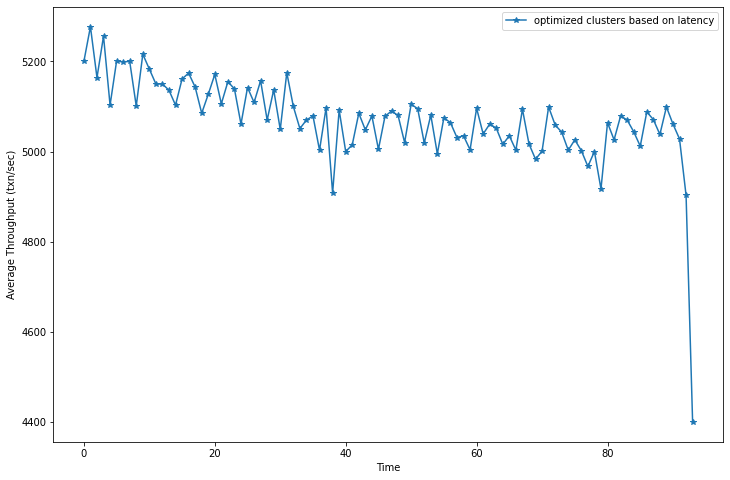

<Figure size 432x288 with 0 Axes>

In [56]:



fig = pl.figure(figsize = (12, 8))
fig.patch.set_facecolor('white')
pl.plot(s1,s2, '-*', label = 'optimized clusters based on latency')


pl.legend()
pl.xlabel('Time')
pl.ylabel('Average Throughput (txn/sec)')
# pl.title('HotStuff Multicluster: Throughput in Optimized Vs Non-Optimized Clusters')

# pl.ylim(0,50)
# pl.savefig('/home/tejas/Desktop/OptClusters.png', dpi =150, bbox_inches = 0 )
pl.show()
pl.clf()

In [57]:
# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# fig.patch.set_facecolor('white')
# pl.plot(s1,s2, '-*', label = 'Hotstuff-MC: Leader Failure')


# pl.legend()
# pl.xlabel('Time')
# pl.ylabel('Throughput (txn/sec)')
# # pl.title('HotStuff Multicluster: Throughput in Optimized Vs Non-Optimized Clusters')

# # pl.ylim(0,50)
# pl.savefig('/home/tejas/Desktop/LeaderFailure_HotStuffMC.png', dpi =150, bbox_inches = 0 )
# pl.show()
# pl.clf()

(0.0, 0.2)

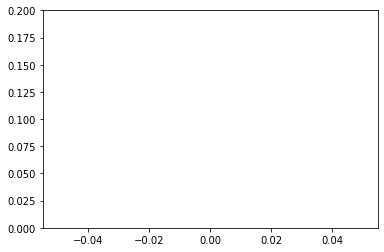

In [58]:
pl.plot(lats)
pl.ylim(0,0.2)

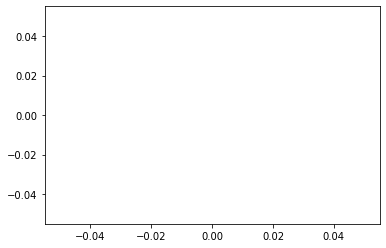

In [59]:
pl.plot(lats)
# pl.ylim(0,0.6)

In [60]:
lats

[]

In [61]:
os.system('grep -n -r "LatencyPlot: new node sending join request message" ../../../dump_files/')

256

In [62]:
os.system('grep -n -r "LatencyPlot: Received first message with new node info" ../../../dump_files/')

256

In [63]:
os.system('grep -n -r "LatencyPlot: Leader received with tentative sets from all peer nodes" ../../../dump_files/')        

256

In [64]:
1000*(32.776365 - 32.768622)

7.742999999997835

In [65]:
os.system('grep -n -r "LatencyPlot: Received second join message" ../../../dump_files/')        

256

In [66]:
os.system('grep -n -r "LatencyPlot: Received initial join message" ../../../dump_files/')        

256

In [67]:
os.system('grep -n -r "Sending Join Init message with height" ../../../dump_files/')        

256

In [68]:
1000*(17.534818-17.534437)

0.3810000000008529

In [69]:
os.system('grep -n -r "LatencyPlot: Sent response to  initial join message" ../../../dump_files/')        

256

In [70]:

    
os.system('grep -n -r "LatencyPlot: Received second join message" ../../../dump_files/')        

256

In [71]:
17.536482

17.536482

In [72]:
# os.system('grep -n -r "quorum reached for second join message with cluster_id" ../../../dump_files/')

In [73]:
# os.system('grep -n -r "LatencyPlot: Received 1st MC message" ../../../dump_files/')

In [74]:
# os.system('grep -n -r "LatencyPlot: before sending first mc message" ../../../dump_files/')

In [75]:
# 1000*(32.676090-32.612236)

In [76]:
# os.system('grep -n -r "LatencyPlot: going to execute based on 2nd MC message" ../../../dump_files/')


# os.system('grep -n -r "LatencyPlot: Finished execution" ../../../dump_files/')

# os.system('grep -n -r "LatencyPlot: Processing message from client" ../../../dump_files/')    

In [77]:
# os.system('grep -n -r "LatencyPlot: before initial join message" ../../../dump_files/')    

In [78]:
# # os.system('grep -n -r "LatencyPlot: " ../../../dump_files/')

# 1000*(11.479877-11.479442), 1000*(11.484887-11.479877),1000*(56.048590-56.046569), 1000*(56.050021 - 56.048590)

# # exec, # first mc, #second mc

# 1000*(56.050377 - 56.050181), 1000*(56.049389-56.049025), 1000*(56.050875-56.049389), 1000*(56.046557-56.038591) 


# # with open('opt1.npy', 'wb') as f:
# #     np.save(f, s1)
# #     np.save(f, s2)
    

    
# # with open('opt1.npy', 'rb') as f:
# #     opt1 = np.load(f)
# #     opt2 = np.load(f)
  
    








# # with open('equiCluster1.npy', 'wb') as f:
# #     np.save(f, s1)
# #     np.save(f, s2)
    

    
# # with open('equiCluster1.npy', 'rb') as f:
# #     eq1 = np.load(f)
# #     eq2 = np.load(f)
  
    
    
    
# # with open('equiCluster.npy', 'rb') as f:
# #     eq1 = np.load(f)
# #     eq2 = np.load(f)

    
# # with open('lat.npy', 'rb') as f:
# #     lat1 = np.load(f)
# #     lat2 = np.load(f)

    
    
# # with open('opt.npy', 'rb') as f:
# #     opt1 = np.load(f)
# #     opt2 = np.load(f)


# fig = pl.figure(figsize = (12, 8))
# fig.patch.set_facecolor('white')
# pl.plot(s1,s2, '-*', label = 'optimized clusters based on latency')

# # pl.plot(eq1,eq2, '-*', label = 'optimized clusters: equal clusters (7 (R1),7 (R2)')
# # pl.plot(lat1,lat2, '-*', label = 'optimized clusters: latency (9 (R1),5 (R2))')
# # pl.plot(opt1,opt2, '-*', label = 'optimized clusters: latency and heterogeneity (4 (R1),5 (R1), 5 (R2))')
# pl.legend()
# pl.xlabel('Time')
# pl.ylabel('Average Throughput (txn/sec)')
# # pl.title('HotStuff Multicluster: Throughput in Optimized Vs Non-Optimized Clusters')

# # pl.ylim(0,350)
# # pl.savefig('/home/tejas/Desktop/OptClusters.png', dpi =150, bbox_inches = 0 )
# pl.show()
# pl.clf()

0
0
ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-15-206-93-127.ap-south-1.compute.amazonaws.com -T "sudo rm -f nohup.out;"
0
0
ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-13-234-226-135.ap-south-1.compute.amazonaws.com -T "sudo rm -f nohup.out;"
0
0
0
ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-13-233-224-80.ap-south-1.compute.amazonaws.com -T "sudo rm -f nohup.out;"
0
0
5 ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-3-110-33-61.ap-south-1.compute.amazonaws.com  -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec5.conf >../nohup.out 2>&1 &"
0
ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-3-110-120-142.ap-south-1.compute.amazonaws.com -T "sudo rm -f nohup.out;"
7 ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-13-233-64-189.ap-south-1.compute.amazonaws.com  -T "cd hotstuffO; sudo

0
0
ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-3-109-185-208.ap-south-1.compute.amazonaws.com -T "sudo rm -f nohup.out;"
20 ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-3-111-147-214.ap-south-1.compute.amazonaws.com  -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec20.conf >../nohup.out 2>&1 &"
0
0
0
ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-43-205-232-139.ap-south-1.compute.amazonaws.com -T "sudo rm -f nohup.out;"
17 ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-13-235-24-55.ap-south-1.compute.amazonaws.com  -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec17.conf >../nohup.out 2>&1 &"
0
0
ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-13-234-217-72.ap-south-1.compute.amazonaws.com -T "sudo rm -f nohup.out;"
25 ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem

0
0
ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-13-232-12-61.ap-south-1.compute.amazonaws.com -T "sudo rm -f nohup.out;"
14 ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-13-126-0-127.ap-south-1.compute.amazonaws.com  -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec14.conf >../nohup.out 2>&1 &"
ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-15-206-93-127.ap-south-1.compute.amazonaws.com -T "cd hotstuffO; sudo nohup ./examples/hotstuff-client --idx 0 --iter -1 --max-async 400 >../nohup.out 2>&1 &"
0
0
ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-13-126-0-127.ap-south-1.compute.amazonaws.com -T "sudo rm -f nohup.out;"
32 ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-13-233-141-45.ap-south-1.compute.amazonaws.com  -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec32.conf >../nohup.out

## Single Non-Leader Failure

experiment = 'test'
os.system('rm hotstuff.gen*')
os.system('sh job_mini.sh '+ experiment)

os.system('cp hotstuff.gen* ../../')

os.system('cd ../../; git add .; git commit -m "testing rvc on server"; git push -f')

    
results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(setup_remote2)(i)\
                                                                       for i in node_info_dict['node_id'])


print(results)  

results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(compile_remote)(i)\
                                                                       for i in node_info_dict['node_id'])


print(results)  

results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(clean_nodes_remote)(i)\
                                                                       for i in node_info_dict['node_id'])


print(results) 

def run_server_node_remote(i):
    ip = node_info_dict['publicIP'][i] 
#     if ip!='None' and( ip in nodeIps[:-3]):

    if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com  -T "cd hs; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec'+str(node_info_dict['ServerID'][i])+'.conf >../nohup.out 2>&1 &"'
        
        print(i,command)
        os.system(command)
        
        
    
for i in node_info_dict['publicIP']:
    run_server_node_remote(i)
    
    
time.sleep(20)



def run_client_node_remote(i):
    ip = node_info_dict['publicIP'][i] 

    if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hs; sudo nohup ./examples/hotstuff-client --idx '+str(node_info_dict['clientID'][i])+' --iter -1 --max-async 40 >../nohup.out 2>&1 &"'
        
        print(command)
        os.system(command)




    
results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(run_client_node_remote)(i)\
                                                                       for i in node_info_dict['node_id'])


print(results)  

    
# for i in node_info_dict['publicIP']:
#     run_client_node_remote(i)

time.sleep(40)

for i in node_info_dict['publicIP']:
    if i==3:
        print(i)
        kill_nodes_remote(i)

time.sleep(45)

for i in node_info_dict['publicIP']:
    kill_nodes_remote(i)


for i in node_info_dict['publicIP']:
    ip = node_info_dict['publicIP'][i] 

    if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com:/home/ubuntu/nohup.out ../../../dump_files/nohup_client_'+str(node_info_dict['clientID'][i])+'.out'
        print(command)
        os.system(command)

experiment = '../../dump_files'
X,Y, lats = getThroughput(experiment)
print(np.sum(Y)/len(Y), np.average(lats))

fig = pl.figure(figsize = (12, 8))
fig.patch.set_facecolor('white')
pl.plot(X[:-2],Y[:-2], '-*')
pl.axvline(x=40, ls='--', color = 'red')
pl.xlabel('Time')
pl.ylabel('Average Throughput (txn/sec)')
pl.title('HotStuff Multicluster: Single Non-Leader Failure')

# pl.ylim(0,1000)
pl.savefig('/home/tejas/Desktop/NodeFailure.png', dpi =150, bbox_inches = 0 )
pl.show()
pl.clf()

## Single Leave

## Multiple Non Leader Failure

experiment = 'test'
os.system('rm hotstuff.gen*')
os.system('sh job_mini.sh '+ experiment)

os.system('cp hotstuff.gen* ../../')

os.system('cd ../../; git add .; git commit -m "testing rvc on server"; git push -f')

    
results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(setup_remote2)(i)\
                                                                       for i in node_info_dict['node_id'])


print(results)  

results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(compile_remote)(i)\
                                                                       for i in node_info_dict['node_id'])


print(results)  

results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(clean_nodes_remote)(i)\
                                                                       for i in node_info_dict['node_id'])


print(results) 

def run_server_node_remote(i):
    ip = node_info_dict['publicIP'][i] 
#     if ip!='None' and( ip in nodeIps[:-3]):

    if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com  -T "cd hs; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec'+str(node_info_dict['ServerID'][i])+'.conf >../nohup.out 2>&1 &"'
        
        print(i,command)
        os.system(command)
        
        
    
for i in node_info_dict['publicIP']:
    run_server_node_remote(i)
    
    
time.sleep(20)



def run_client_node_remote(i):
    ip = node_info_dict['publicIP'][i] 

    if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hs; sudo nohup ./examples/hotstuff-client --idx '+str(node_info_dict['clientID'][i])+' --iter -1 --max-async 40 >../nohup.out 2>&1 &"'
        
        print(command)
        os.system(command)




    
results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(run_client_node_remote)(i)\
                                                                       for i in node_info_dict['node_id'])


print(results)  

    
# for i in node_info_dict['publicIP']:
#     run_client_node_remote(i)

time.sleep(40)

for i in node_info_dict['publicIP']:
    if i==3:
        print(i)
        kill_nodes_remote(i)
        
time.sleep(20)

for i in node_info_dict['publicIP']:
    if i==7:
        print(i)
        kill_nodes_remote(i)
        
time.sleep(20)

for i in node_info_dict['publicIP']:
    if i==11:
        print(i)
        kill_nodes_remote(i)

time.sleep(45)

for i in node_info_dict['publicIP']:
    kill_nodes_remote(i)


for i in node_info_dict['publicIP']:
    ip = node_info_dict['publicIP'][i] 

    if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com:/home/ubuntu/nohup.out ../../../dump_files/nohup_client_'+str(node_info_dict['clientID'][i])+'.out'
        print(command)
        os.system(command)

experiment = '../../dump_files'
X,Y, lats = getThroughput(experiment)
print(np.sum(Y)/len(Y), np.average(lats))

fig = pl.figure(figsize = (12, 8))
fig.patch.set_facecolor('white')
pl.plot(X[:-2],Y[:-2], '-*')
pl.axvline(x=40, ls='--', color = 'red')
pl.axvline(x=60, ls='--', color = 'green')
pl.axvline(x=80, ls='--', color = 'blue')

pl.xlabel('Time')
pl.ylabel('Average Throughput (txn/sec)')
pl.title('HotStuff Multicluster: Multiple Non-Leader Failure')

# pl.ylim(0,1000)
pl.savefig('/home/tejas/Desktop/MultiNodeFailure.png', dpi =150, bbox_inches = 0 )
pl.show()
pl.clf()

## Single Leave